In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2.5
    minIzero = 0.01
    lin_filter = 0.2
    image_threshold = 2
    hot_pixel = 6

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 25, nshots=None)
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Time_pump, Time_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    
    Time_pump = np.mean(Time_pump)
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
    print('numon')
    print(IzeroFEL_pump.shape[0])
    
    print('numoff')
    print(IzeroFEL_unpump.shape[0])
    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    images_thr_on[np.isnan(images_thr_on)] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0
    images_thr_off[np.isnan(images_thr_off)] = 0
    
    print('num nan')
    print(sum(sum(sum(np.isnan(images_thr_on)))))
    
    print('Izero')
    print(np.mean(IzeroFEL_unpump))
    print(np.mean(IzeroFEL_pump))
    print(np.max(IzeroFEL_unpump))
    print(np.min(IzeroFEL_unpump))
    
    IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump = \
        filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
    

    
    print(images_thr_on.shape)
    print(images_thr_on.shape)
    
    images_thr_on = images_thr_on[condFinalPump]
    images_thr_off = images_thr_off[condFinalUnPump]

    print('number of surviving frames')
    print(images_thr_on.shape[0])
    print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    XES_on[np.isnan(XES_on)] = 0
    XES_off[np.isnan(XES_off)] = 0
    
    print('num nan')
    print(sum(sum(np.isnan(XES_on))))
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
    print(XES_on.shape)
    print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp
        
    FloFEL_pump_total = np.mean(DataFluo_pump)/np.mean(IzeroFEL_pump)
    FloFEL_unpump_total = np.mean(DataFluo_unpump)/np.mean(IzeroFEL_unpump)
    
    return XES_on, XES_off, Time_pump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

    condition = np.logical_and(Y<260, Y>253)
    Z[condition] = 0
    
    Z[Y>320] = 0
    Z[Y < 200] = 0

    condition = np.logical_not(np.logical_and(X<200, X>130))
    Z[condition] = 0

    #plt.figure()
    #plt.imshow(Z)
    
    #plt.colorbar()
    
    return Z

Run for RIXS

In [5]:
scannum_01 = [11]

scannum = scannum_01

for jj in range(len(scannum)):
    
    filename_base = "RuDimerACN_timescan_0" + '%02d' % scannum[jj] + "_step00"
    scan_name = "RuDimerACN_timescan_0" + '%02d' % scannum[jj]
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 20+1
    #numfiles = 3

    Time_on_01 = np.empty(numfiles)
    
    fluo_Pump = np.empty(numfiles)
    fluo_Unpump = np.empty(numfiles)
    

    for ii in range(numfiles):

        XES_on, XES_off, time_pump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_delay_SH, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            rixs_on_01 = XES_on.sum(axis=0)
            rixs_off_01 = XES_off.sum(axis=0)
        else:
            rixs_on_01 = np.vstack((rixs_on_01,XES_on.sum(axis=0)))
            rixs_off_01 = np.vstack((rixs_off_01,XES_off.sum(axis=0)))
            
        Time_on_01[ii] = time_pump
        fluo_Pump[ii] = fluo_pump
        fluo_Unpump[ii] = fluo_unpump
            
        
    if jj == 0:
        
        RIXS_on_01 = rixs_on_01
        RIXS_off_01 = rixs_off_01
        Fluo_pump_01 = fluo_Pump
        Fluo_unpump_01 = fluo_Unpump
        
    else:
        
        RIXS_on_01 = RIXS_on_01 + rixs_on_01
        RIXS_off_01 = RIXS_off_01 + rixs_off_01
        Fluo_pump_01 = Fluo_pump_01 + fluo_Pump
        Fluo_unpump_01 = Fluo_unpump_01 + fluo_Unpump



/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.05194866997562349
0.0525643911305815
0.13595494627952576
0.012272312305867672
(500, 512, 300)
(500, 512, 300)
number of surviving frames
481
486
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.052589987326413394
0.05146404560469091
0.14358437061309814
0.01477810274809599
(500, 512, 300)
(500, 512, 300)
number of 

num nan
0
Izero
0.051169206729158756
0.05006675615720451
0.13542693853378296
0.00824542436748743
(500, 512, 300)
(500, 512, 300)
number of surviving frames
483
486
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0016.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0016.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.05024104144073499
0.051224899170920254
0.1431443691253662
3.630026913015172e-05
(500, 512, 300)
(500, 512, 300)
number of surviving frames
489
486
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0017.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_011/RuDimerACN_timescan_011_step0017.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
pas

In [6]:
print(sum(sum(np.isnan(RIXS_off_01))))

0


In [7]:
scannum_02 = [12]

scannum = scannum_02

for jj in range(len(scannum)):
    
    filename_base = "RuDimerACN_timescan_0" + '%02d' % scannum[jj] + "_step00"
    scan_name = "RuDimerACN_timescan_0" + '%02d' % scannum[jj]
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 20+1
    #numfiles = 3

    Time_on_02 = np.empty(numfiles)
    eV_off_02 = np.empty(numfiles)
    
    fluo_Pump = np.empty(numfiles)
    fluo_Unpump = np.empty(numfiles)
    

    for ii in range(numfiles):

        XES_on, XES_off, time_pump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_delay_SH, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            rixs_on_02 = XES_on.sum(axis=0)
            rixs_off_02 = XES_off.sum(axis=0)
        else:
            rixs_on_02 = np.vstack((rixs_on_02,XES_on.sum(axis=0)))
            rixs_off_02 = np.vstack((rixs_off_02,XES_off.sum(axis=0)))
            
        Time_on_02[ii] = time_pump
        fluo_Pump[ii] = fluo_pump
        fluo_Unpump[ii] = fluo_unpump
            
        
    if jj == 0:
        
        RIXS_on_02 = rixs_on_02
        RIXS_off_02 = rixs_off_02
        Fluo_pump_02 = fluo_Pump
        Fluo_unpump_02 = fluo_Unpump
        
    else:
        
        RIXS_on_02 = RIXS_on_02 + rixs_on_02
        RIXS_off_02 = RIXS_off_02 + rixs_off_02
        Fluo_pump_02 = Fluo_pump_02 + fluo_Pump
        Fluo_unpump_02 = Fluo_unpump_02 + fluo_Unpump

/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.04954351707175374
0.0496166358217597
0.1340881586074829
0.008923670276999474
(500, 512, 300)
(500, 512, 300)
number of surviving frames
487
482
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.05217155202105642
0.05216837527602911
0.16045726835727692
0.008702008984982967
(500, 512, 300)
(500, 512, 300)
number of s

num nan
0
Izero
0.05353805138543248
0.0527217682171613
0.15579821169376373
0.013057420961558819
(500, 512, 300)
(500, 512, 300)
number of surviving frames
484
481
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0016.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0016.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
numon
500
numoff
500
number of frames
500
500
num nan
0
Izero
0.05438958729803562
0.05604053153283894
0.14200963079929352
0.017674241214990616
(500, 512, 300)
(500, 512, 300)
number of surviving frames
484
488
num nan
0
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0017.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_012/RuDimerACN_timescan_012_step0017.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passe

<IPython.core.display.Javascript object>


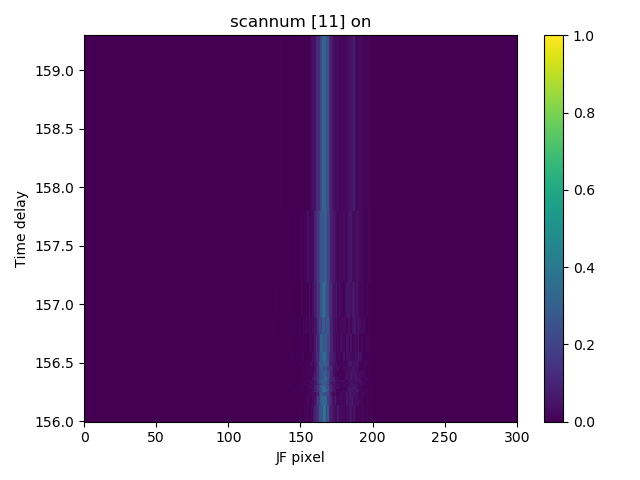

<IPython.core.display.Javascript object>


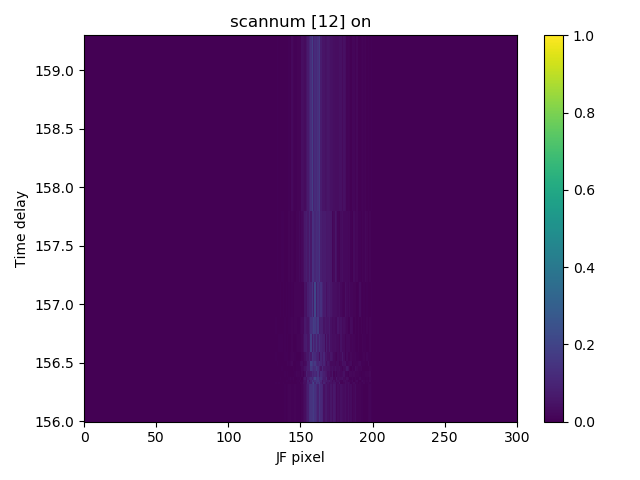

In [8]:
X,Y = np.meshgrid(np.linspace(0,RIXS_on_01.shape[1],RIXS_on_01.shape[1]+1),Time_on_01)
plt.figure()
plt.pcolor(X,Y,RIXS_on_01, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Time delay')
plt.title('scannum ' + str(scannum_01) + ' on')

# X,Y = np.meshgrid(np.linspace(0,RIXS_off_01.shape[1],RIXS_off_01.shape[1]+1),eV_off_01)
# plt.subplot(2,1,2)
# plt.pcolor(X,Y,RIXS_off_01, vmax = 1)
# plt.colorbar()
# plt.xlabel('JF pixel')
# plt.ylabel('Mono Energy (eV)')
# plt.title('scannum ' + str(scannum_01) + ' off')

plt.tight_layout()


X,Y = np.meshgrid(np.linspace(0,RIXS_on_02.shape[1],RIXS_on_02.shape[1]+1),Time_on_02)
plt.figure()
plt.pcolor(X,Y,RIXS_on_02, vmax = 1)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Time delay')
plt.title('scannum ' + str(scannum_02) + ' on')

# X,Y = np.meshgrid(np.linspace(0,RIXS_off_02.shape[1],RIXS_off_02.shape[1]+1),eV_off_02)
# plt.subplot(2,1,2)
# plt.pcolor(X,Y,RIXS_off_02, vmax = 1)
# plt.colorbar()
# plt.xlabel('JF pixel')
# plt.ylabel('Mono Energy (eV)')
# plt.title('scannum ' + str(scannum_02) + ' off')

plt.tight_layout()

<IPython.core.display.Javascript object>


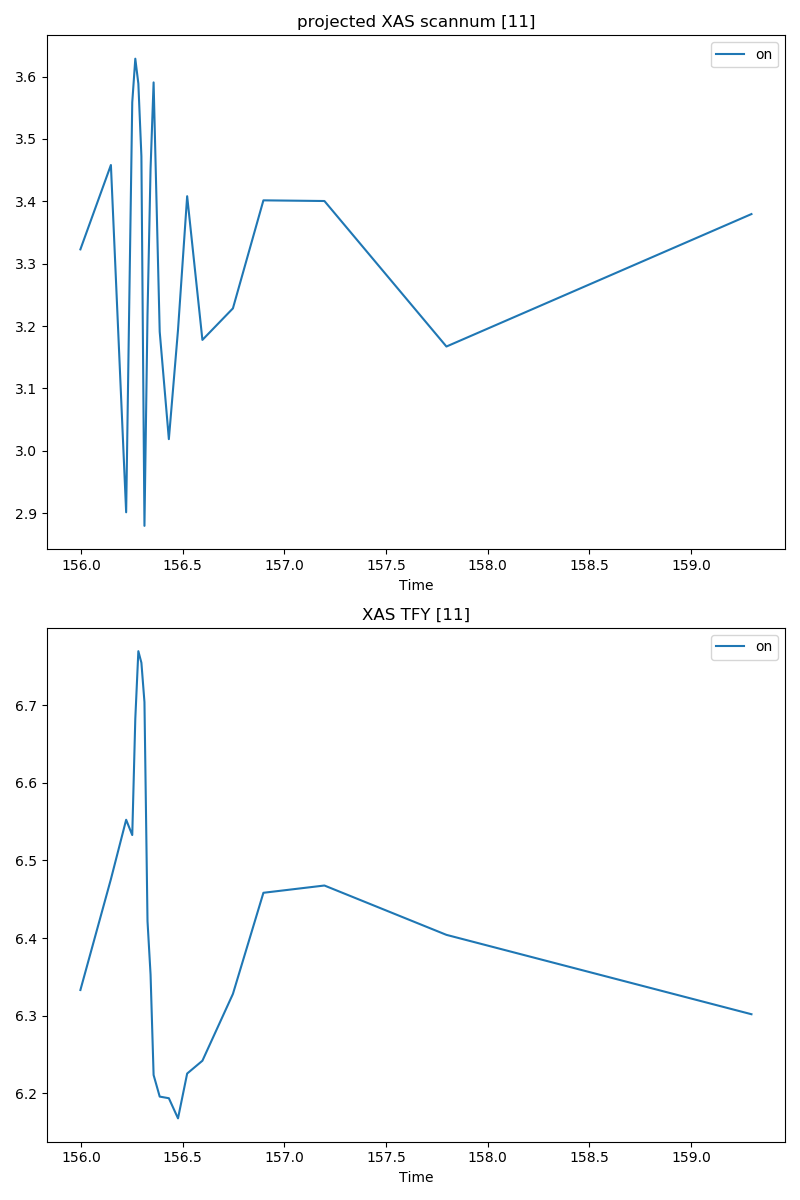

<IPython.core.display.Javascript object>


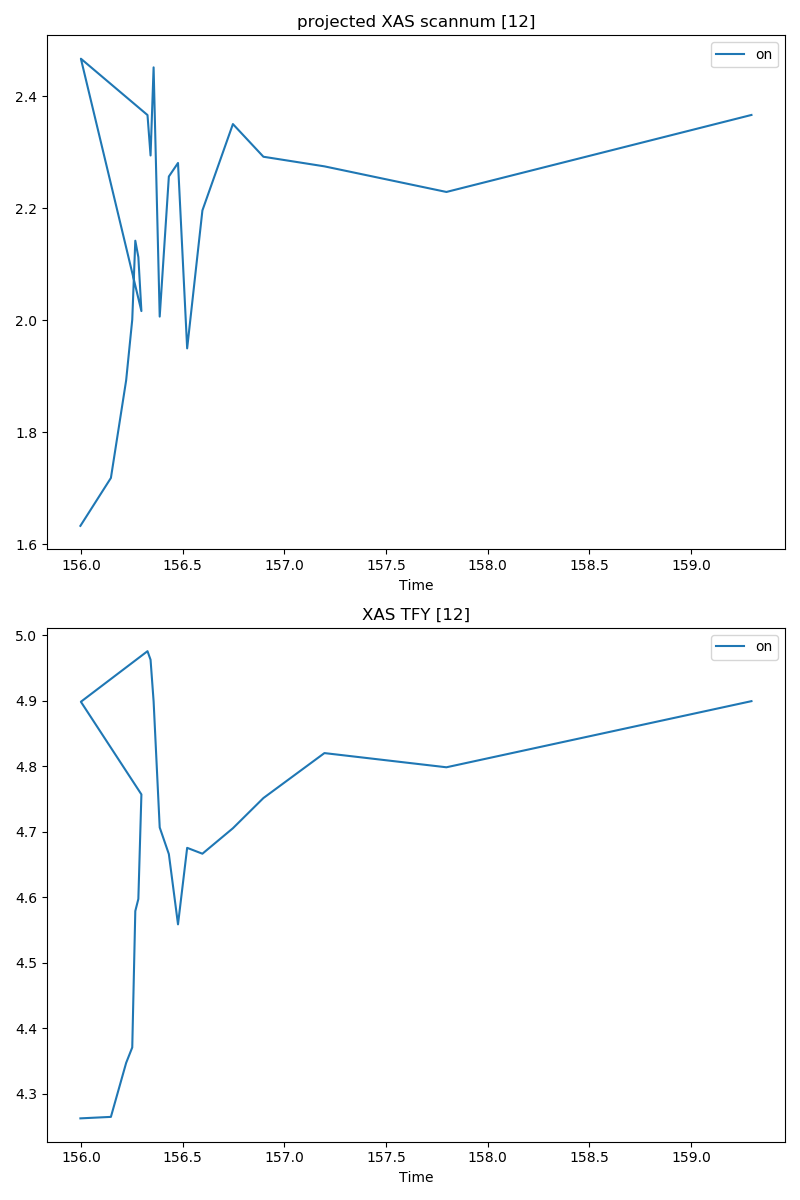

[155.99759855 156.14760155 156.22259935 156.25259523 156.26759927
 156.28260191 156.29759375 156.31260139 156.32760023 156.34260107
 156.35759811 156.38760279 156.43259651 156.47759943 156.52260075
 156.59759735 156.74759575 156.89759975 157.19759935 157.79760074
 159.29759834]
[155.99760095 156.14759475 156.22260755 156.25259503 156.26760227
 156.28259491 156.29759375 155.9999785  156.32759503 156.34260627
 156.35759611 156.38759879 156.43260171 156.47759623 156.52259455
 156.59760595 156.74760115 156.89760075 157.19759995 157.79759494
 159.29759994]


In [9]:
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.plot(Time_on_01, RIXS_on_01.sum(axis=1), label = "on")
plt.xlabel('Time')
plt.title('projected XAS scannum ' + str(scannum_01))
plt.legend()

plt.subplot(2,1,2)
plt.plot(Time_on_01, Fluo_pump_01, label = "on")
plt.xlabel('Time')
plt.title('XAS TFY ' + str(scannum_01))
plt.legend()

plt.tight_layout()


plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.plot(Time_on_02, RIXS_on_02.sum(axis=1), label = "on")
plt.xlabel('Time')
plt.title('projected XAS scannum ' + str(scannum_02))
plt.legend()

plt.subplot(2,1,2)
plt.plot(Time_on_02, Fluo_pump_02, label = "on")
plt.xlabel('Time')
plt.title('XAS TFY ' + str(scannum_02))
plt.legend()


plt.tight_layout()

print(Time_on_01)
print(Time_on_02)